In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow import feature_column
from tensorflow.keras import layers

import numpy as np

The target at time n will be sin(x1<sub>n-1</sub>) + cos(x2<sub>n-1</sub>) + tan(x1<sub>n-1</sub> + x2<sub>n-1</sub>) where x1 and x2 are the features. Both x1 and x2 are randomly generated numbers between -1 and 1. The LAG response will be a binary variable if positive/negative

In [2]:
import pandas as pd

df = pd.read_csv('data/data.csv')
df['LAG_response'] = df['response'].shift(-1)  ## 1 time step lag
df = df.dropna()
df['LAG_response'] = pd.Categorical(df['LAG_response'] < 0)
#df = df.drop(['response'], axis=1)
dates = df.pop('date')

for col in df.columns: 
    df = df.rename({col: col.replace(' ', '_').replace('&', '')}, axis=1)

df

,x1,x2,response,LAG_response
1,-0.892401,0.163061,0.839180,True
2,-0.609522,0.950474,-0.685575,False
3,-0.169819,-0.536533,0.363630,True
4,0.460706,-0.448193,-0.162723,False
5,-0.045847,-0.821941,1.358325,True
...,...,...,...,...
732,-0.006947,0.544640,1.000797,False
733,0.374841,0.858580,1.444666,False
734,0.580474,0.698402,3.870374,False
735,-0.844387,-0.439188,4.642028,True


In [3]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('LAG_response')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [4]:
### normalize features
from sklearn.preprocessing import StandardScaler
y = df.pop('LAG_response')

def normalize_column(df):
    scaler = StandardScaler()
    df = pd.DataFrame(scaler.fit_transform(df.values), columns = df.columns, index= df.index)
    df = pd.DataFrame(np.clip(df, -5, 5), columns = df.columns, index= df.index)
    return df
        
df = normalize_column(df)
df['LAG_response'] = y.values

total_ds = df_to_dataset(df, shuffle=False, batch_size=len(df))
total_df = df.copy()

df.describe()

,x1,x2,response
count,7.360000e+02,7.360000e+02,736.000000
mean,2.111837e-18,1.077980e-16,0.037905
std,1.000680e+00,1.000680e+00,0.481164
min,-1.763215e+00,-1.722513e+00,-5.000000
25%,-8.649978e-01,-8.514864e-01,0.048075
50%,4.847800e-02,-1.763602e-02,0.071143
75%,8.815953e-01,8.212859e-01,0.095204
max,1.706569e+00,1.774070e+00,5.000000


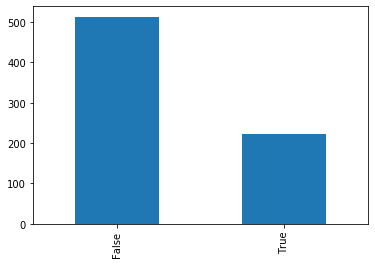

In [5]:
df['LAG_response'].value_counts().plot(kind='bar')

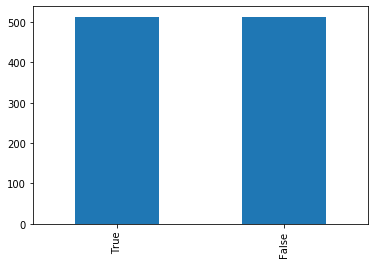

In [6]:
### oversample categorical y to rebalance
data_negativeResponse = df[df['LAG_response']]
data_positiveResponse = df[df['LAG_response'] != True]
choices = np.random.choice(len(data_negativeResponse), len(data_positiveResponse))
sample_negativeResponse = data_negativeResponse.iloc[choices]
df = pd.concat([sample_negativeResponse,data_positiveResponse]) 
df['LAG_response'].value_counts().plot(kind='bar')


In [7]:
# train and test dataset splits
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.3)
batch_size = len(df)
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)


In [8]:
feature_columns = []
headers = [
            "x1", 
            "x2"
          ]
# numeric cols
for header in headers:
    feature_columns.append(feature_column.numeric_column(header))


In [9]:
def make_model(bias, threshold=0.5):
    if bias is not None:
        bias = keras.initializers.Constant(bias)
    model = tf.keras.Sequential()
    # Add feature layer
    model.add(layers.DenseFeatures(feature_columns))
    # Adds a densely-connected layer with 64 units to the model:
    model.add(layers.Dense(64, activation='relu'))
    #model.add(layers.Dropout(0.5))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(100, activation='relu'))
    # Add the output layer:
    model.add(layers.Dense(1, activation='sigmoid', bias_initializer= bias))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=[keras.metrics.BinaryAccuracy(threshold=threshold), keras.metrics.Precision(thresholds=threshold), keras.metrics.Recall(thresholds=threshold), 
                           keras.metrics.AUC(name="auc")])
    
    return model

In [10]:
##output_bias 
print(df['LAG_response'].value_counts())
#initial_bias = np.log([lacking_samples/overflowing_samples])

#plot loss
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_loss(model_fit, label, n, other_metric=None):
    plt.semilogy(model_fit.epoch, model_fit.history['loss'], color=colors[n], label="Train "+label)
    plt.semilogy(model_fit.epoch, model_fit.history['val_loss'], color=colors[n], label='Val '+label, linestyle='--')
    if other_metric:
        plt.plot(model_fit.epoch, model_fit.history[other_metric], color=colors[n], label=other_metric, linestyle='dashdot')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

#model = make_model(None)
#plot_loss(model.fit(train_ds, epochs=50, verbose=0,validation_data=val_ds), "Default bias", 0)

#model = make_model(initial_bias)
#plot_loss(model.fit(train_ds, epochs=50, verbose=0,validation_data=val_ds), "Custom bias", 1)


True     513
False    513
Name: LAG_response, dtype: int64


In [11]:
model = make_model(None, 0.6)

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_auc", min_delta=0.001, patience=15, mode="max")
model.fit(train_ds, epochs=500, verbose=2,validation_data=val_ds, callbacks=[earlystop_callback])

Epoch 1/500
1/1 - 5s - loss: 0.8140 - binary_accuracy: 0.5105 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.3411 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 2/500
1/1 - 0s - loss: 0.7862 - binary_accuracy: 0.5105 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7613 - val_loss: 0.7619 - val_binary_accuracy: 0.5081 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9072
Epoch 3/500
1/1 - 0s - loss: 0.7620 - binary_accuracy: 0.5105 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8925 - val_loss: 0.7406 - val_binary_accuracy: 0.5081 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9255
Epoch 4/500
1/1 - 0s - loss: 0.7408 - binary_accuracy: 0.5105 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9229 - val_loss: 0.7219 - val_binary_accuracy: 0.5081 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9304
Epoch 5/500
1/1 - 0s - l

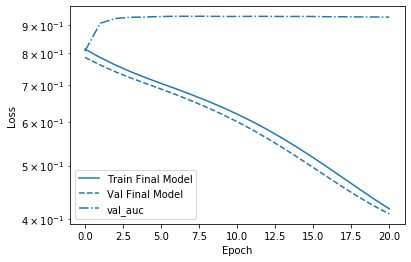

In [12]:
plot_loss(model.history, "Final Model", 0, 'val_auc')

In [13]:
model.evaluate(test_ds)

pred_results = model.predict(test_ds)

#for i in range(len(predicted)):
    #print("X=%s, Y=%s, Predicted=%s" % (dict(test[headers].iloc[i]), test['LAG_response'].array[i], pred_results[i]))
    #print("Y=%s, Predicted=%s" % (test['LAG_response'].array[i], pred_results[i]))
    
predicted = test.copy()[headers]
predicted["LAG_response"] = test["LAG_response"]
predicted["Prob(response < 0)"] = pred_results
predicted_correctly = []
for i in range(0, len(predicted["Prob(response < 0)"])):
    if (predicted["Prob(response < 0)"].array[i] > 0.5 and predicted["LAG_response"].array[i] == True) \
        or (predicted["Prob(response < 0)"].array[i] < 0.5 and predicted["LAG_response"].array[i] == False):
        predicted_correctly.append(1)
    else:
        predicted_correctly.append(0)
predicted["Predicted correctly"] = predicted_correctly
predicted["date"] = dates
predicted.to_csv("results.csv")
predicted[["LAG_response", "Prob(response < 0)", "Predicted correctly"]]

1/1 [==============================] - 0s 9ms/step - loss: 0.4000 - binary_accuracy: 0.9223 - precision: 0.9358 - recall: 0.9189 - auc: 0.9346


,LAG_response,Prob(response < 0),Predicted correctly
8,True,0.690023,1
157,False,0.180108,1
334,False,0.269497,1
255,False,0.256718,1
655,True,0.268469,0
...,...,...,...
547,False,0.275127,1
104,True,0.738151,1
598,True,0.668466,1
218,False,0.572250,0


In [14]:
# predicting over full history, i.e. including in-sample
model.evaluate(total_ds)
pred_results_full = model.predict(total_ds)

predicted_full = total_df.copy()[headers]
predicted_full["LAG_response"] = total_df["LAG_response"]
predicted_full["Prob(response < 0)"] = pred_results_full
predicted_correctly = []
for i in range(0, len(predicted_full["Prob(response < 0)"])):
    if (predicted_full["Prob(response < 0)"].array[i] > 0.5 and predicted_full["LAG_response"].array[i] == True) \
        or (predicted_full["Prob(response < 0)"].array[i] < 0.5 and predicted_full["LAG_response"].array[i] == False):
        predicted_correctly.append(1)
    else:
        predicted_correctly.append(0)
predicted_full["Predicted correctly"] = predicted_correctly
predicted_full["Date"] = dates
predicted_full.to_csv("results_full.csv")
predicted_full[["LAG_response", "Prob(response < 0)", "Predicted correctly"]]

1/1 [==============================] - 0s 16ms/step - loss: 0.4165 - binary_accuracy: 0.9402 - precision: 0.8908 - recall: 0.9148 - auc: 0.9386


,LAG_response,Prob(response < 0),Predicted correctly
1,True,0.795733,1
2,False,0.404718,1
3,True,0.638397,1
4,False,0.213020,1
5,True,0.695529,1
...,...,...,...
732,False,0.252632,1
733,False,0.235520,1
734,False,0.268577,1
735,True,0.857728,1


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  192       
_________________________________________________________________
dense_1 (Dense)              multiple                  6500      
_________________________________________________________________
dense_2 (Dense)              multiple                  10100     
_________________________________________________________________
dense_3 (Dense)              multiple                  10100     
_________________________________________________________________
dense_4 (Dense)              multiple                  101       
Total params: 26,993
Trainable params: 26,993
Non-trainable params: 0
____________________________________________________